In [22]:
import requests
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import argparse
import pandas as pd
import requests
import math
from io import StringIO
import warnings
import logging
import pathlib
import shutil
import geopandas as gpd
import contextily as ctx
from glob import glob
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [35]:
input_shapefile_dir = '../data/shapefiles'
input_file = '../data/state_county/ar_ashley.csv.xz'

In [36]:
lat_lon_df = pd.read_csv(input_file)
lat_lon_df

,state,county,zip,longitude,latitude,address,id
0,ar,ashley,71635,-91.963568,33.123666,"301 west 9th avenue,crossett,ar,71635",ar_ashley
1,ar,ashley,71635,-91.949543,33.121913,"1100 camp road,crossett,ar,71635",ar_ashley
2,ar,ashley,71635,-91.950245,33.121784,"1100 camp road,crossett,ar,71635",ar_ashley
3,ar,ashley,71635,-91.949614,33.118393,"1300 pecan street,crossett,ar,71635",ar_ashley
4,ar,ashley,71635,-91.960783,33.126432,"701 main street,crossett,ar,71635",ar_ashley
...,...,...,...,...,...,...,...
12985,ar,ashley,71661,-91.616955,33.122743,"433 ashley 351 road,parkdale,ar,71661",ar_ashley
12986,ar,ashley,71661,-91.484689,33.127085,"381 ashley 45 road,parkdale,ar,71661",ar_ashley
12987,ar,ashley,71646,-91.748783,33.269232,"521 ashley 70 road,hamburg,ar,71646",ar_ashley
12988,ar,ashley,71635,-92.043261,33.116475,"118 pinewood road,crossett,ar,71635",ar_ashley


# Retrieve all zip file references

In [139]:
prefix = 'https://www2.census.gov/geo/tiger/TIGER2020PL/LAYER/TABBLOCK/2020/'
r= requests.get(prefix)
soup = BeautifulSoup(r.content)
shape_zips = []
for a in soup.find_all('a', href=True):
    if not '.zip' in a['href'] or len(a['href'])!= 28: # filter for the entire state ones
        continue
    shape_zips.append(a['href'])
print(len(shape_zips))

3221


In [48]:
test_zip = [z for z in zips if '05003' in z]
test_zip

['tl_2020_05003_tabblock20.zip']

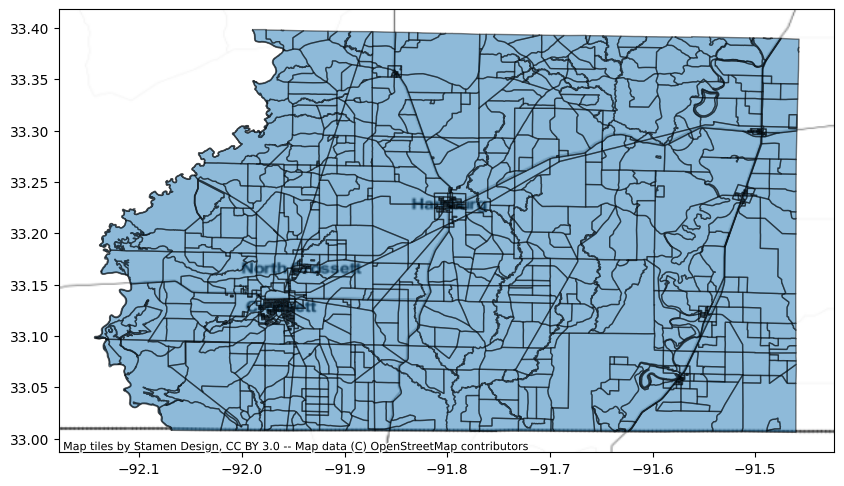

In [49]:
state_df = gpd.read_file(prefix+test_zip[0])
state_df.crs= 4326
ax = state_df.plot(figsize=(10, 10), alpha=0.5, edgecolor='black')
ctx.add_basemap(ax, zoom=10, crs=state_df.crs.to_string(), source=ctx.providers.Stamen.Toner)

In [89]:
fsdf = pd.read_csv('../data/fips_state.csv')
fsdf

,fips,state,abbr
0,1,alabama,al
1,2,alaska,ak
2,4,arizona,az
3,5,arkansas,ar
4,6,california,ca
5,8,colorado,co
6,9,connecticut,ct
7,10,delaware,de
8,11,district_of_columbia,dc
9,12,florida,fl


In [176]:
def main(
    state_fip, 
    lat_lon_df,
    input_shapefile_dir,
):
    warnings.filterwarnings("ignore")    
    
    state_shape_files = [v for v in shape_zips if v.split('_')[2][:2]==state_fip]    
    assert len(state_shape_files) > 0, print(state_fip)
    
    for sf in state_shape_files:
        state_df = gpd.read_file(prefix+sf)
        
        # Spatial join the address with points and the jeffesron county blocks with polygons
        test_df = lat_lon_df.sjoin(state_df, how="right", predicate="intersects")
        if len(test_df[~test_df['GEOID20'].isnull()]) > 0:
            lat_lon_df = test_df
            lat_lon_df = lat_lon_df[
                ["address", "GEOID20", 'longitude', 'latitude']
            ]
            # print(isinstance(lat_lon_df, gpd.GeoDataFrame))
            lat_lon_df = lat_lon_df.rename(columns={"GEOID20": "geoid20"})
            break
            
    assert ('geoid20' in lat_lon_df and 'GEOID20' in state_df), print(lat_lon_df.columns)
    
    vc = lat_lon_df['geoid20'].value_counts()
#     perc_coverage = len(lat_lon_df['geoid20'].unique()) / len(state_df['GEOID20'].unique()) * 100    
#     report = pd.DataFrame({
#         'county_fip': county_fip, 
#         'perc_coverage:': perc_coverage, 
#         'median': vc.median(), 
#         'std': vc.std(),
#     },index=[0])
    
    return lat_lon_df

In [37]:
cgdf = gpd.GeoDataFrame(
    lat_lon_df,
    geometry=gpd.points_from_xy(lat_lon_df.longitude, lat_lon_df.latitude),
)
cgdf

,state,county,zip,longitude,latitude,address,id,geometry
0,ar,ashley,71635,-91.963568,33.123666,"301 west 9th avenue,crossett,ar,71635",ar_ashley,POINT (-91.96357 33.12367)
1,ar,ashley,71635,-91.949543,33.121913,"1100 camp road,crossett,ar,71635",ar_ashley,POINT (-91.94954 33.12191)
2,ar,ashley,71635,-91.950245,33.121784,"1100 camp road,crossett,ar,71635",ar_ashley,POINT (-91.95025 33.12178)
3,ar,ashley,71635,-91.949614,33.118393,"1300 pecan street,crossett,ar,71635",ar_ashley,POINT (-91.94961 33.11839)
4,ar,ashley,71635,-91.960783,33.126432,"701 main street,crossett,ar,71635",ar_ashley,POINT (-91.96078 33.12643)
...,...,...,...,...,...,...,...,...
12985,ar,ashley,71661,-91.616955,33.122743,"433 ashley 351 road,parkdale,ar,71661",ar_ashley,POINT (-91.61696 33.12274)
12986,ar,ashley,71661,-91.484689,33.127085,"381 ashley 45 road,parkdale,ar,71661",ar_ashley,POINT (-91.48469 33.12709)
12987,ar,ashley,71646,-91.748783,33.269232,"521 ashley 70 road,hamburg,ar,71646",ar_ashley,POINT (-91.74878 33.26923)
12988,ar,ashley,71635,-92.043261,33.116475,"118 pinewood road,crossett,ar,71635",ar_ashley,POINT (-92.04326 33.11648)


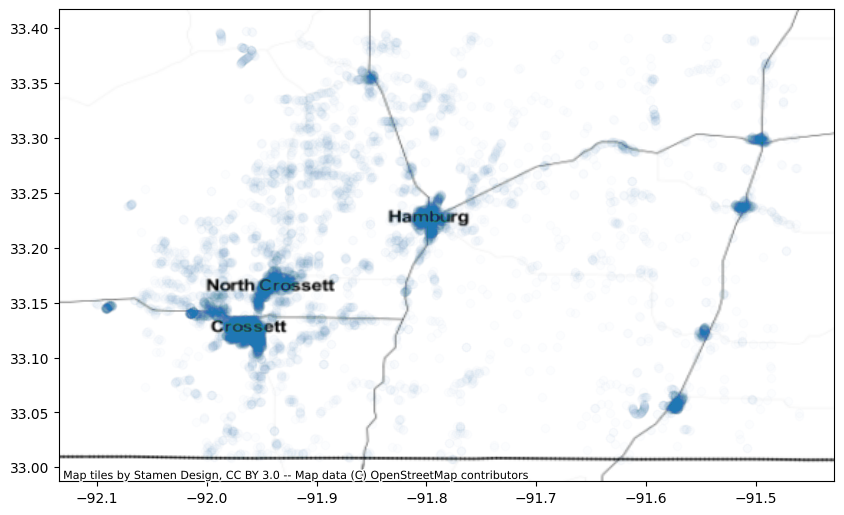

In [40]:
cgdf.crs= 4326
ax = cgdf.plot(figsize=(10, 10), alpha=0.01)
ctx.add_basemap(ax, zoom=10, crs=cgdf.crs.to_string(), source=ctx.providers.Stamen.Toner)

In [170]:
lat_lon_df, county_fip, report = main('05', cgdf, input_shapefile_dir)
print(county_fip)
print(report)

05001
  county_fip  perc_coverage:  median  std
0      05001           100.0     1.0  0.0


In [85]:
lat_lon_df

,address,geoid20,geometry
0,"1510 south louisiana street,crossett,ar,71635",050039606003013,"POLYGON ((-91.97813 33.11813, -91.97788 33.118..."
0,"1508 south louisiana street,crossett,ar,71635",050039606003013,"POLYGON ((-91.97813 33.11813, -91.97788 33.118..."
0,"1506 south louisiana street,crossett,ar,71635",050039606003013,"POLYGON ((-91.97813 33.11813, -91.97788 33.118..."
0,"1504 south louisiana street,crossett,ar,71635",050039606003013,"POLYGON ((-91.97813 33.11813, -91.97788 33.118..."
0,"1608 south louisiana street,crossett,ar,71635",050039606003013,"POLYGON ((-91.97813 33.11813, -91.97788 33.118..."
...,...,...,...
1480,"120 ashley 705 road,crossett,ar,71635",050039604001130,"POLYGON ((-91.97750 33.03716, -91.97752 33.040..."
1480,"120 ashley 705 road,crossett,ar,71635",050039604001130,"POLYGON ((-91.97750 33.03716, -91.97752 33.040..."
1480,"120 ashley 705 road,crossett,ar,71635",050039604001130,"POLYGON ((-91.97750 33.03716, -91.97752 33.040..."
1480,"120 ashley 705 road,crossett,ar,71635",050039604001130,"POLYGON ((-91.97750 33.03716, -91.97752 33.040..."


# Itereate through all files in data/state_county, and export it to data/county_address/ under <county_fip>.csv.xz

In [175]:
d = '../data/state_county'
pbar = tqdm(sorted([v for v in os.listdir(d) if v.split('.')[-1] == 'xz']))
for c in pbar:
    pbar.set_description('Processing: %s' % c)
    state_fips = str(fsdf[fsdf['abbr'] == c.split('_')[0]]['fips'].values[0]).zfill(2)
    lat_lon_df = pd.read_csv(os.path.join(d, c))
    cgdf = gpd.GeoDataFrame(
        lat_lon_df,
        geometry=gpd.points_from_xy(lat_lon_df.longitude, lat_lon_df.latitude),
    )
    final_df = main(state_fips, cgdf, input_shapefile_dir)
    reports.append(report)
    pbar.set_description('Saving to: %s' % c)
    final_df.to_csv('../data/county_address/%s_mapped.csv.xz'% c.split('.csv.xz')[0], index=False)

Saving to: az_gila.csv.xz:   8%|▊         | 139/1802 [07:06<1:24:57,  3.07s/it]                          


KeyboardInterrupt: 